# Mass-spring-damper system estimation via Kalman Filter

In [1]:
import symforce.symbolic as sf
import matplotlib.pyplot as plt
import numpy as np

from symforce.notebook_util import display
%matplotlib inline

In [2]:
# Governing Equation
# m * a + c * v + k * x = f

# STATE 
# q = [x]
#     [v]

# STATE DERIVATIVE
# qdot = [v]
#        [a]

# PLUG THINGS IN
# qdot = [q1],
#         [a]

# a = (f - k * x - c * v) / m
# a = (f - k * q0 - c * q1)/ m

# qdot = [q1]
#        [f - k*q0 - c*q1]

# LINEAR SYSTEM:
# qdot =  [ 1    0]   @  [q0]  +  [ 0 ] @ f
#         [-k/m -c/m]    [q1]     [1/m]

# Or... we do this with symforce

In [11]:
x, v, a, f, m, k, c = sf.symbols('x v a f m k c')

q = sf.V2(x, v)
qdot = sf.V2(v,a)
qdot = qdot.subs(a, (f - k * x - c * v) / m)

A = qdot.jacobian(q)
B = qdot.jacobian(f)

print("A = ")
display(A)

print("B = ")
display(B)


A = 


⎡ 0    1 ⎤
⎢        ⎥
⎢-k   -c ⎥
⎢───  ───⎥
⎣ m    m ⎦

B = 


⎡0⎤
⎢ ⎥
⎢1⎥
⎢─⎥
⎣m⎦

# First Task:
We want to create a simulation of the mass-spring-damper system: <br>
Complete the following code:



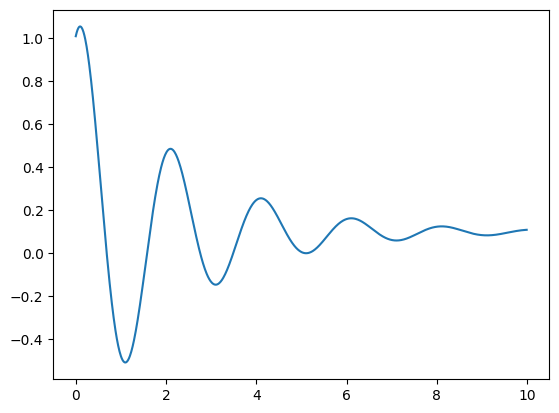

In [2]:
#INITALIZE
m = 1.0
k = 10.0
c = 1.0

t_0 = 0
dt = 0.01
t_final = 10

q = np.array([1,1]).reshape(-1,1)
A = np.array([[0, 1],
             [-k/m, -c/m]])
B = np.array([[0],
             [1/m]])
f = 1.0
t_vec =  np.arange(t_0, t_final, dt)
x_history = []

#SIMULATION
for t in t_vec:
    #------------YOUR CODE HERE------------------#
    #compute qdot, q (you can use euler integration)
    qdot = A @ q + B * f
    q = q + qdot * dt
    #------------YOUR CODE HERE------------------#
    
    x_history.append(q[0])

#PLOT
plt.figure()
plt.plot(t_vec, x_history)
plt.show()

# We want to add noisy position measurement and noisy force
h(x) ~ Normal (mu = x, std = 0.05) </br>
f ~ Normal (mu = 1, std = 3) </br>
</br>

you can use: </br> 
np.random.normal(mu,std)

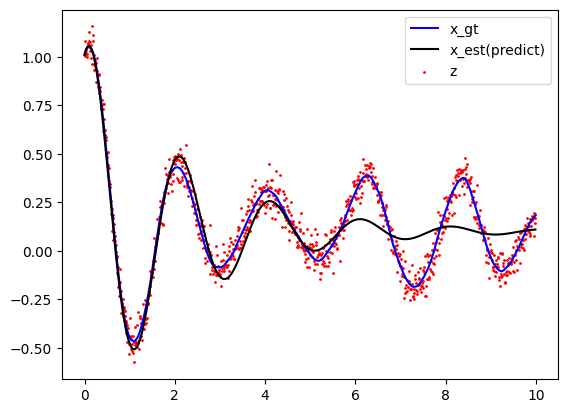

In [3]:
#INITALIZE
m = 1.0
k = 10.0
c = 1.0

t_0 = 0
dt = 0.01
t_final = 10

A = np.array([[0, 1],
             [-k/m, -c/m]])
B = np.array([[0],
             [1/m]])
t_vec =  np.arange(t_0, t_final, dt)

q_gt = np.array([1,1]).reshape(-1,1)
q_est = np.array([1,1]).reshape(-1,1)

x_gt_history = []
x_est_history = []
z_history = []
#SIMULATION
for t in t_vec:
    # compute qdot_gt, q_gt, z
    f_est = 1.0
    f_real = np.random.normal(1.0,3)
    
    #------------YOUR CODE HERE------------------#
    qdot_gt = A @ q_gt + B * f_real
    q_gt = q_gt + qdot_gt * dt
    z = np.random.normal(q_gt[0],0.05)
    qdot_est = A @ q_est + B * f_est
    q_est = q_est + qdot_est * dt
    #------------YOUR CODE HERE------------------#

    x_gt_history.append(q_gt[0])
    x_est_history.append(q_est[0])
    z_history.append(z)

#PLOT
plt.figure()
plt.plot(t_vec, x_gt_history, color = 'blue')
plt.plot(t_vec, x_est_history, color = 'black')
plt.scatter(t_vec, z_history, s = 1, color = 'red')
plt.legend(['x_gt', 'x_est(predict)', 'z'])
plt.show()

# Lets add the Kalman filter to improve Estimation on x

In [6]:
#INITALIZE
m = 1.0
k = 10.0
c = 1.0

t_0 = 0
dt = 0.01
t_final = 10

A = np.array([[0, 1],
             [-k/m, -c/m]])
B = np.array([[0],
             [1/m]])
H = np.array([[1.0, 0]])

t_vec =  np.arange(t_0, t_final, dt)

q_gt = np.array([1,1]).reshape(-1,1)
q_est_mu = np.array([1,1]).reshape(-1,1)
q_est_cov = np.eye(2) * 1e-15

x_gt_history = []
x_est_history = []
z_history = []
x_est_std_history = []

Q = np.eye(2)  #<------TUNE THESE
R = np.array([[0.05**2]])  #<------TUNE THESE
def kalman(q_prev, cov_prev, f, z):
    #------------YOUR CODE HERE------------------#
    #compute mu, cov.
    #You can use Probablistic Robotics page 36

    #predict
    qdot = A @ q_prev + B * f
    mu_bar = q_prev + qdot * dt
    cov_bar = A @ cov_prev @ A.T + Q
    
    #update
    K = cov_bar @ H.T @ np.linalg.inv(H @ cov_bar @ H.T + R)
    mu = mu_bar + K @ (z - H @ mu_bar)
    cov = (np.eye(2) - K @ H) @ cov_bar
    #------------YOUR CODE HERE------------------#
    return mu, cov

#SIMULATION
for t in t_vec:
    f_real = np.random.normal(1.0,3)
    qdot_gt = A @ q_gt + B * f_real
    q_gt = q_gt + qdot_gt * dt
    z = np.random.normal(q_gt[0],0.05)

    f_est = 1.0
    q_est_mu, q_est_cov = kalman(q_est_mu, q_est_cov ,f_est ,z)

    x_gt_history.append(q_gt[0])
    x_est_history.append(q_est_mu[0])
    x_est_std_history.append(np.sqrt(q_est_cov[0,0]))
    z_history.append(z)

#PLOT
x_est_history = np.array(x_est_history).squeeze()
x_est_std_history = np.array(x_est_std_history)

%matplotlib auto

plt.figure()
plt.plot(t_vec, x_gt_history, color = 'blue')
plt.plot(t_vec, x_est_history + 1 *x_est_std_history, color = 'black')
plt.plot(t_vec, x_est_history - 1 *x_est_std_history, color = 'black')
plt.scatter(t_vec, z_history, s = 1, color = 'red')
plt.legend(['x_gt', 'x_est(kalman)_up', 'x_est(kalman)_down', 'z'])
plt.show()

Using matplotlib backend: TkAgg
